# RIp : Réponse impulsionnelle 



L'acoustique de la salle de concert de Pori en Finlande a été identifiée par la méthode de la réponse impulsionnelle :
 * un haut parleur omnidirectionnel envoie un claquement le plus proche possible d'une impulsion de Dirac depuis la scène
 * deux micro placés dans la salle sur un manequin enregistre le signal : c'est **l'enregistrement binaural**
 
 On peut récupérer ces réponses impulsionnelles gracieusement mises à disposition sur  [IR Concert Hall de Pori, Finlan](http://legacy.spa.aalto.fi/projects/poririrs/) . Prenons l'enregistrement binaural `s3_r4_b.wav` et remercions-les.
 
 On va utiliser cette RIp qui caractérise le canal acoustique entre la scène et un membre du public pour 
 
 > transformer un signal audio (sans relief et en mono) en *un signal stereo avec le relief du Concert Hall de Pori*.

## 1 - Mise en forme de la RIp

Récupérons le signal `RIp_s3_r4_b.wav` contenant la réponse impulsionnelle stéréo. On a donc deux réponses impulsionnelles caractérisant deux canaux de transmission du signal :
 - le canal acoustique de la scène vers l'oreille droite d'un spectateur
 - celui de l'oreille gauche
 
 La fonction `audiored` renvoie une matrice des deux signaux dont les valeurs sont codées en flottant où $[+1, -1]$ représente la pleine échelle du signal.
 
 Un signal supérieur à 1 en valeur absolue sera saturé à l'écoute.

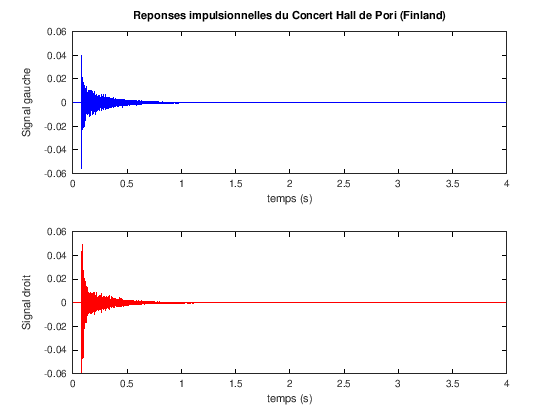

In [81]:
clear all;
% on se place dans  Signal/discret/cours/notebooks/
racine = pwd; racine = [racine(1:(findstr(racine,"Signal")+6)), "discret/cours/notebooks/"];cd (racine);

% de là le fichier .wav peut être interprété
[h,Fs]=audioread("RIp_s3_r4_b.wav");

% vecteur temps [s] et nombre d'échantillons Nh
Nh = length(h); t=1:Nh; t= t-1; t=t/Fs;

% Affichage
subplot(211)
plot(t,h(:,1),'b');
xlabel("temps (s)"); ylabel("Signal gauche");
title('Reponses impulsionnelles du Concert Hall de Pori (Finland)')
subplot(212)
plot(t,h(:,2),'r')
xlabel("temps (s)"); ylabel("Signal droit");


On remarque que :
 * la RIp est nulle pendant quelques milliers d'échantillons avant que le signal n'arrive.
 * la RIp devient quasi nulle au bout d'une seconde 
 * l'amplitude est inférieure à 0.05 signifiant 5% de la pleine échelle
 
 Observons les statistiques des deux signaux et comparons avec les normes :
  - $N_1$ : $\|s\|_1 = \frac{1}{N} \sum\limits_{j=0}^{N-1} |s[j]|$
  - $N_2$ : $\|s\|_2 = \sqrt{ \frac{1}{N} \sum\limits_{j=0}^{N-1} |s[j]|^2}$
  - $N_\infty$  : $\|s\|_\infty=\mathop\max\limits_{0 \le j < N} |s[j]|$ 

In [82]:
function [N1,N2,Ninf] = stats_signal_mono(s, nom="Signal")
    Ninf = max(max(abs(s)));
    N2 = sqrt(sum(abs(s).^2)/length(s));
    N1 = sum(abs(s))/length(s);
    
    printf ([nom, " N1=%d   <  N2=%d   <   NInf= %d\n"],
            N1,N2,Ninf)
    printf ([nom," borné dans  %d ...  %d   => NInf = %d \n"],
            min(s),max(s),Ninf)
    printf ([nom,"  i.i.d.  %d (moy) +/- %d (std)\n"], 
                mean(s), std(s))
    printf ([nom," moy^2    \t+   std^2    \t=        \t<->   \t N2^2\n"]); 
    printf ([nom," %d \t+ %d  \t=  %d  \t<-> \t %d\n"], 
                mean(s)^2, std(s)^2, mean(s)^2 + std(s)^2, N2^2)
                
end

function stats_signal_stereo(s, nom="Signal")
    disp ("_____________________________\n");
    disp ([nom, " STEREO:\n"]);
    disp ("Gauche :\n");
    stats_signal_mono(s(:,1),["  "]);
    disp ("Droite :\n");
    stats_signal_mono(s(:,2),["  "]);
    disp ("_____________________________\n")
    disp("Matrice de covariance gauche droite = \n");
    disp(s'*s/length(s))
    disp("\n\n");
end

stats_signal_stereo(h,"RIp")



_____________________________

RIp STEREO:

Gauche :

   N1=0.000216457   <  N2=0.000871879   <   NInf= 0.0554627
   borné dans  -0.0554627 ...  0.0401613   => NInf = 0.0554627 
    i.i.d.  4.2508e-08 (moy) +/- 0.000871881 (std)
   moy^2    	+   std^2    	=        	<->   	 N2^2
   1.80693e-15 	+ 7.60177e-07  	=  7.60177e-07  	<-> 	 7.60173e-07
Droite :

   N1=0.000235863   <  N2=0.00104428   <   NInf= 0.0588199
   borné dans  -0.0588199 ...  0.0490125   => NInf = 0.0588199 
    i.i.d.  -2.99867e-08 (moy) +/- 0.00104428 (std)
   moy^2    	+   std^2    	=        	<->   	 N2^2
   8.99204e-16 	+ 1.09052e-06  	=  1.09052e-06  	<-> 	 1.09052e-06
_____________________________

Matrice de covariance gauche droite = 

   7.6017e-07   3.9352e-08
   3.9352e-08   1.0905e-06





Les normes du signal sont faibles, un tel filtre va atténuer fortement un signal mis en entrée.
Nous allons enlever sa valeur moyenne résiduelle et l'amplifier pour le normer. Nous respectons la différence de volume entre gauche et droite.
On veut donc qu'en moyenne sur gauche et droite la norme 2 soit de 1.

On veut donc :
  - Enlever le retard global des deux signaux en cherchant la valeur `start` à partir de laquelle un des des deux signaux devient significativement non nul.
  - Enlever la partie au-delà d'une seconde qui est quasi-nulle pour ne pas ajouter inutilement de bruit
  - Normaliser le signal de telle sorte que sa puissance moyenne (norme 2) soit unitaire 

In [83]:
start = 1;
while (max(abs(h(start,:))) < 1e-4)
    start=start +1;
end
start
distance = start/Fs*330  % en mètre pour son à 330 m/s
h_base = h;
h_pre = h_base(start:end,:); % on coupe le debut null
% on raccourci pour avoir environ 1 à 2 s
h = h_pre(1:(1.2*Fs),:); 
Nh=length(h)
h = (h-mean(h)); % on enlève le résidu de composante continue

% On regarde l'écart type moyen qui est la racine de N2
ecart_type_moyen_gauche_droite = mean(std(h)); 

% on amplifie les deux signaux pour les normer
h = h / ecart_type_moyen_gauche_droite ;

stats_signal_stereo(h,"RIp normalisée")

% l'écart type moyen (droite-gauche)doit être de 1
ecart_type_moyen_gauche_droite = mean(std(h))

start =  3600
distance =  24.750
Nh =  57600
_____________________________

RIp normalisée STEREO:

Gauche :

   N1=0.408702   <  N2=0.910018   <   NInf= 31.7079
   borné dans  -31.7079 ...  22.9601   => NInf = 31.7079 
    i.i.d.  2.13516e-18 (moy) +/- 0.910026 (std)
   moy^2    	+   std^2    	=        	<->   	 N2^2
   4.55889e-36 	+ 0.828147  	=  0.828147  	<-> 	 0.828132
Droite :

   N1=0.445491   <  N2=1.08996   <   NInf= 33.6272
   borné dans  -33.6272 ...  28.0204   => NInf = 33.6272 
    i.i.d.  -1.94343e-18 (moy) +/- 1.08997 (std)
   moy^2    	+   std^2    	=        	<->   	 N2^2
   3.77693e-36 	+ 1.18804  	=  1.18804  	<-> 	 1.18802
_____________________________

Matrice de covariance gauche droite = 

   0.828132   0.042869
   0.042869   1.188023



ecart_type_moyen_gauche_droite =  1.0000


## 2 - Mise en forme du signal d'entrée
On récupère un signal de voix et on s'assure qu'il est bien plat (sans relief) en isolant le canal gauche.

On regarde ses statistiques pourmesure la puissance de ce signal.

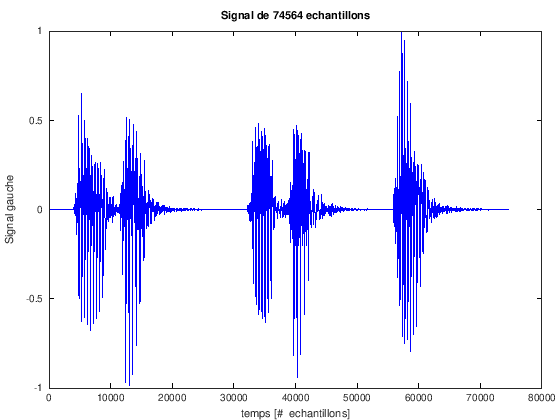

In [4]:
[x,Fs_x]=audioread("RIp_un_deux.wav");
if (Fs != Fs_x) 
    disp("fréquences échantillonnage différentes !\n Il faut ré-échantillonner");
else
    Nx=length(x);
    x = x(:,1); % On rend Mono en enlevant le droit
end

plot(x,'b');
xlabel("temps [#  echantillons]"); ylabel("Signal gauche");
title(sprintf('Signal de %d echantillons',Nx))

x_base = x;



In [5]:
stats_signal_mono(x, "x MONO ")

x MONO  N1=0.0586641   <  N2=0.132737   <   NInf= 0.999998
x MONO  borné dans  -0.985788 ...  0.999998   => NInf = 0.999998 
x MONO   i.i.d.  1.34312e-06 (moy) +/- 0.132738 (std)
x MONO  moy^2    	+   std^2    	=        	<->   	 N2^2
x MONO  1.80397e-12 	+ 0.0176193  	=  0.0176193  	<-> 	 0.017619
ans =  0.058664


Le signal d'entrée est **normé en norme Infinie** c'est à dire coincé entre -1 et 1. 
> Ce signal a été mis en pleine échelle pour qu'il ne sature pas.

Sa puissance moyenne (norme 2) est de 0.13 : nous essaieront d'obtenir un signal filtré de même puissance (volume).

## 3 - Filtrage en temporel

On calcule les sortie de chaque canaux acoustique et donc deux produits de convolution :
  - $y_g = x \star h_g$  pour l'oreille gauche
  - $y_d = x \star h_d$  pour la droite
On obtient ainsi une réponse stéréo "comme si" le signal est arrivé à nos oreille à travers la salle de concert.

On peut calculer le produit de convolution par linéarité :
> $\vec{x} = \sum_j x[j] \vec{\delta[j]} \implies y = \sum_j x[j] . \vec{h[\bullet-j]}$

Il est alors évident que si $x$ à $N_x$ points et $h$ en a $N_h$ :
  - le premier instant non nul de la convolution est le premier de $x[0].\vec{h}$  et donc le premier du signal $h$ pour l'indice $1$
  - le dernier instant non nul de la convolution est le dernier de $x[N_x-1].\vec{h[\bullet-(N_x-1)]}$ et donc pour la fin de $\vec{h[\bullet-(N_x-1)]}$ qui est un signal de longueur $N_h$ retardé de $N_x-1$ soit pour l'indice $N_x+N_h-1$
  - le reste de la réponse étant null

Il s'agit d'un calcul de $N_x*N_h$ multiplication/addition qui ici est de l'ordre de 100k*75k soit environ 7 Gflo (Giga FLOating point opérations).
Avec des accès à la RAM pour lecture/écriture cela peut être long.

> chronométrons !

In [6]:
Ny = Nx+Nh-1;

printf("Calcul de la réponse de \n");
printf("    2  \tfiltres (gauche et droit)\n");
printf(" x %d  \tl'ordre d'un filtre h\n",Nh);
printf(" x %d \tvaleurs du signal d'entrée\n", Nx)
printf(" =%d Gflo de calcul", Nx*Ny*2/1e9)
disp(" ! \n\nOn chronomètre...");

y = zeros(Ny,2);

tic;
for k = 1:Nx 
    y(k:k+Nh-1,1) += x(k) .* h(:,1);
    y(k:k+Nh-1,2) += x(k) .* h(:,2);
end 
ela=toc;
printf(" ça fait %d secondes. \n Soit une efficacité de %d Gflops",ela,Nx*Ny*2/1e9/ela); 

Calcul de la réponse de 
    2  	filtres (gauche et droit)
 x 57600  	l'ordre d'un filtre h
 x 74564 	valeurs du signal d'entrée
 =19.7092 Gflo de calcul ! 

On chronomètre...
 ça fait 12.4276 secondes. 
 Soit une efficacité de 1.58593 Gflops

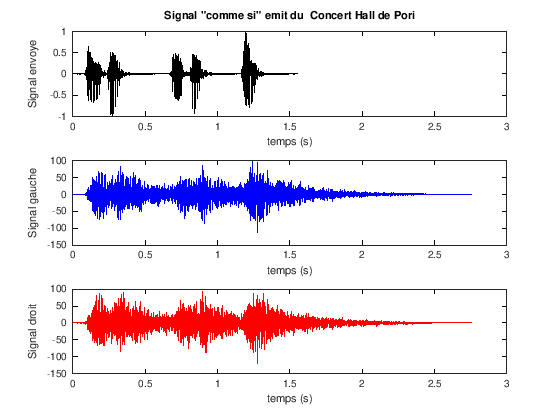

In [7]:
t=1:Ny; t= t-1; t=t/Fs;

subplot(311)
x_pad = [x; NaN(Ny-Nx,1)];
plot(t,x_pad,'k');
xlabel("temps (s)"); ylabel("Signal envoye");
title('Signal "comme si" emit du  Concert Hall de Pori')
subplot(312)
plot(t,y(:,1),'b');
xlabel("temps (s)"); ylabel("Signal gauche");
subplot(313)
plot(t,y(:,2),'r')
xlabel("temps (s)"); ylabel("Signal droit");


In [8]:
% On veut une réponse de la même longueur que y :
% on complète alors x avec des zéro en fin de signal. 
% Comme aux concerts classiques, on attend 1 à 4 secondes
% entendre les derniers échos de la salle avant de huer ;-)
x_pad = [x; zeros(Ny-Nx,1)];
tic;
y_f1 = filter(h(:,1),1,x_pad);
y_f2 = filter(h(:,2),1,x_pad);
ela = toc;
yf = [y_f1 , y_f2];


printf(" ça fait %d secondes. \n",ela);
printf("Soit une puissance de %d Gflops",
        Nx*Ny*2/1e9/ela); 

 ça fait 18.1732 secondes. 
Soit une puissance de 1.08452 Gflops

In [9]:
err = y-yf;
err_cov_mat=err'*err;
printf("Différence entre les signaux de %d et %d [V^2/sample]\n",err_cov_mat(1,1),err_cov_mat(2,2))

Différence entre les signaux de 0 et 0 [V^2/sample]


In [10]:
ynorm = y / mean(std(y)) * std(x);
audiowrite("RIp_y_tempo.wav",ynorm,Fs)


## 4 - Filtrage en fréquenciel : Optimisation du calcul par FFT

Attention en FFt le signal est rendu périodique !

> la convolution est cyclique !
> Il faut ajouter des zéros pour que les réponses ne se recouvrent pas avec le périodique
> ou laisser passer le transitoire et ne regarder que le reste

![](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.mathouriste.eu%2F~ajuhel%2FFourier%2Fpapillons_colores.jpg&f=1&nofb=1)


In [11]:
Nl = Nh+Nx-1
H_fft = fft(h,Nl);
tic;
X_fft = fft(x,Nl);
Y_fft = X_fft .* H_fft ;
y_par_fft = ifft(Y_fft) ;
toc


Nl =  132163
Elapsed time is 0.034771 seconds.


In [12]:
est_reel = sum(abs(real(y_par_fft)))/sum(abs(imag(y_par_fft)))
err = (y-real(y_par_fft));
err'*err

est_reel =    1.8043e+15
ans =

   4.9623e-22   7.1006e-24
   7.1006e-24   5.8690e-22



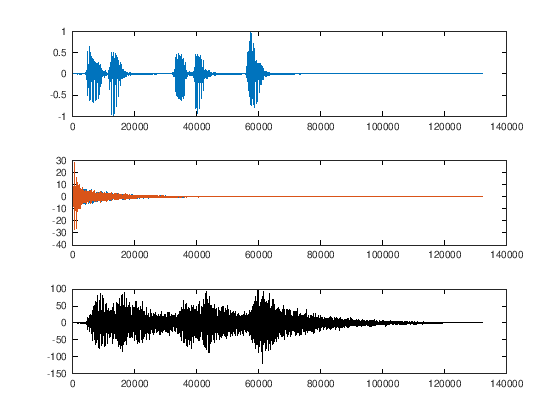

In [13]:

subplot(311);
plot(real(ifft(X_fft)));
subplot(312);
plot(real(ifft(H_fft))); 
%hold on; plot(h,'k')
subplot(313);
plot(real(y_par_fft));
hold on; plot(y,'k');



In [14]:
y_par_fft = y_par_fft / mean(std(y_par_fft)) * std(x);
audiowrite("RIp_y_fft.wav",y_par_fft,Fs)


![](https://image1.slideserve.com/2205031/algorithme-fft-radix-2-cooley-tuckey-19651-l.jpg)

error: 'v' undefined near line 1 column 9
Lx =  960001
Lh =  57601
N =  1017602


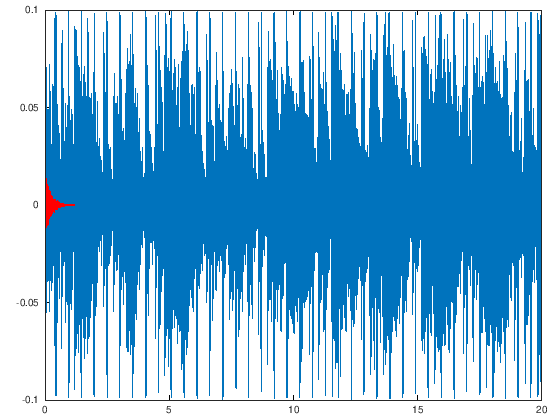

In [17]:
clear all;

[x, Fe] = audioread("./Daft_rock_n_roll.wav");
x = x(Fe*40:60*Fe,:)/10;
size(x);

[h,Fs]=audioread("RIp_s3_r4_b.wav");
start=3600;
h = h(start:(start+1.2*Fs),:);
h = h-mean(h);
size(h);v

Lx = length(x)
Lh = length(h)
N = Lx + Lh

t=0:1/Fe:(N-1)/Fe;

plot(t(1:Lx),x(:,1));
hold on;
plot(t(1:Lh),h(:,1),'r');


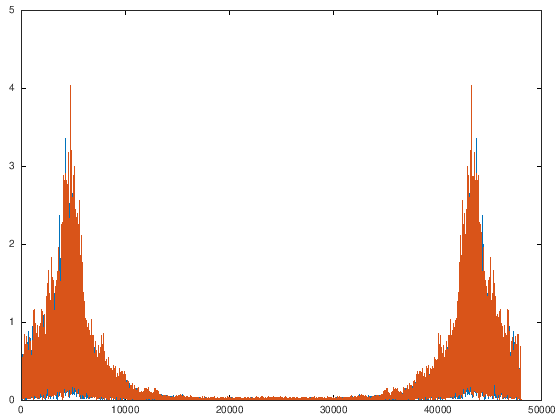

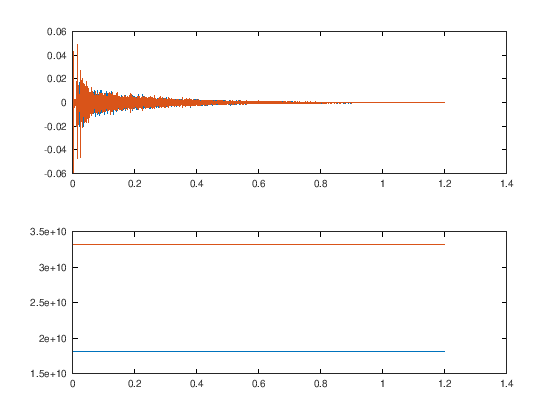

In [23]:
tic;
H = fft(h);
f=(0:(Lh-1))/Lh*Fe;
plot(f,abs(H));
hold on;
HR = conj(H)./abs(H).^2 ;
%plot(f,abs(HR))
hr = real(ifft(HR));
h=real(ifft(H));
figure
subplot(211);
plot(t(1:Lh),h);
subplot(212)
plot(t(1:Lh),hr);


calculs =  0.27921


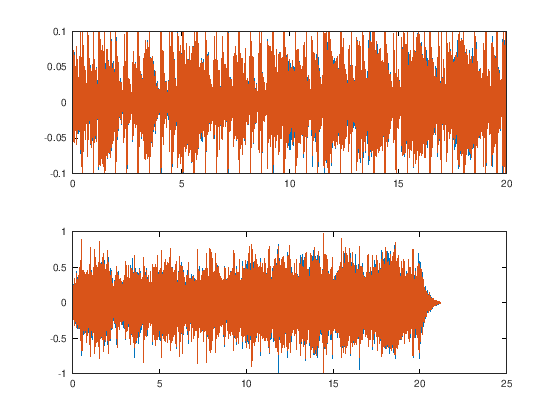

In [8]:

tic;
X = fft(x,N);
H = fft(h,N);
Y = X .* H;
y = real(ifft(Y));
y = y./max(abs(y));
calculs=toc

subplot(211)
plot(t(1:Lx),x);
subplot(212)
plot(t,y);

audiowrite("Daft_Espoo.wav",y(1:(end-Lh)),Fe);